In [128]:
%run "0. config.ipynb"

https://api.redmetrics.io/v1/event.csv?game=0fe53936-027f-461c-b087-b5b5737b2163&gameVersion=51b8a78a-8dd3-4a5e-9f41-01e6805e0f52&entityType=event
48516


# data preparation

In [271]:
def compute_players_type_events(logs):
  df = logs[["playerId", "type"]].copy()
  df["count"] = 1

  df = df.groupby(["playerId", "type"]).agg({ "count" : np.sum })

  df = df.unstack()
  df.columns = df.columns.droplevel()
  df = df.reset_index()
  df = df.fillna(0)
  df = df.set_index([ "playerId" ])
#   print len(df.index)
#   print df.columns
  
  return df

In [280]:
def compute_players_type_events_OLD(logs):
  players_stats = logs.loc[:, ["playerId"]]

  players_stats = players_stats.set_index([ "playerId"] )

  # intitialisation des colonnes
  list_types = list(df_raw.type.unique())

  for type_name in list_types:
    players_stats[type_name] = 0

  # elle sent la connerie cette boucle...
  for i, s in players_stats.iterrows():
  #for i, s in players_stats[0:20].iterrows():
    for t in list_types:
      count = int(df_raw[ (df_raw.playerId == i) & (df_raw.type == t ) ].loc[:, ["type"] ].count())
      players_stats.loc[i, t] = count # this will be way faster if we insert rows instead of cells...

  # this line proves that there is something rotten with for-loop insertion
  players_stats = players_stats.drop_duplicates()

  #players_stats[players_stats.type.unique()] = 0
  players_stats.head(10)
  
  return player_stats

In [324]:
players_stats = compute_players_type_events(df_raw)

In [329]:
def compute_game_durations(logs):

  df = logs.groupby("playerId").agg({ "serverTime": [ np.min, np.max  ] })

  df["duration"] = pd.to_datetime(df["serverTime"]["amax"]) - pd.to_datetime(df["serverTime"]["amin"])
  df["duration"] = df["duration"].map(lambda x: np.timedelta64(x, 's'))

  df = df.loc[:, [("duration", "")]]

  df.columns = df.columns.droplevel()
  df.columns = [ "duration (seconds)" ]

  df["duration (seconds)"] = df["duration (seconds)"].astype(int)/1000000000
  
  return df

In [330]:
players_stats = pd.merge(players_stats, compute_game_durations(df_raw), left_index=True, right_index=True)

In [332]:
players_stats.to_csv("data/players_stats.csv")

In [331]:
players_stats.head()

,complete,configure,craft,death,equip,gotomooc,gotourl,pickup,reach,restart,selectmenu,start,switch,unequip,duration (seconds)
playerId,,,,,,,,,,,,,,,
0023dbb1-7f98-4cdb-8122-722f801f40b3,0,1,0,3,0,0,0,1,2,0,1,0,0,0,175
01b0c435-f0c0-4bfd-9189-86fc0d29b163,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
02bc076b-32aa-467a-bbc6-b746abedb7bd,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
02c6953a-0417-4858-8efb-1989be9f6b9d,0,1,0,0,0,0,0,0,1,0,2,1,1,0,19
0306db66-081d-4035-b30f-8358469d6ec3,1,0,3,17,8,0,1,5,12,1,2,0,0,2,1030


# PCA YOLO

In [113]:
from sklearn.decomposition import PCA

In [333]:
players_stats.mean()

complete                0.156028
configure               0.205674
craft                   0.312057
death                   4.198582
equip                   1.347518
gotomooc                0.007092
gotourl                 0.070922
pickup                  1.049645
reach                   3.425532
restart                 0.014184
selectmenu              1.184397
start                   0.680851
switch                  0.191489
unequip                 0.390071
duration (seconds)    570.815603
dtype: float64

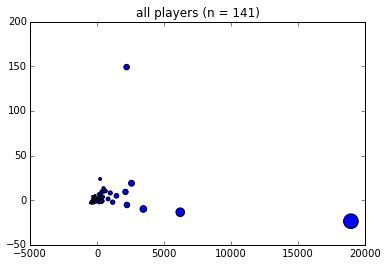

In [334]:
X = players_stats.as_matrix()
n = X.shape[0]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

d = 20 * players_stats["duration (seconds)"] / players_stats["duration (seconds)"].std()

plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], s= d) #, c=c, label=target_name)
plt.title("all players (n = %s)" % (n))
plt.legend()


we skipped gotomooc because there is no enough data


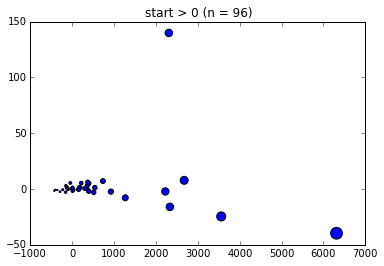

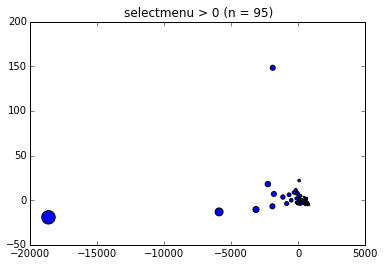

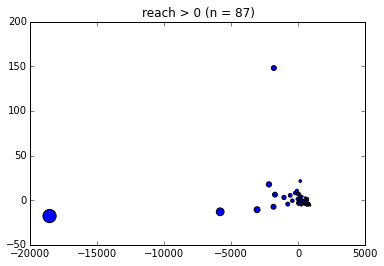

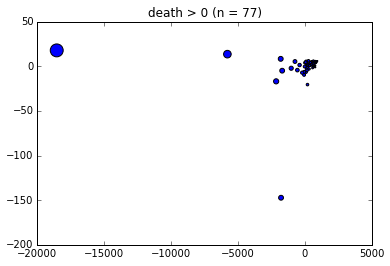

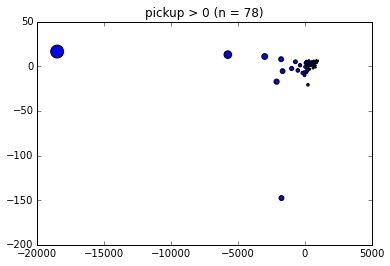

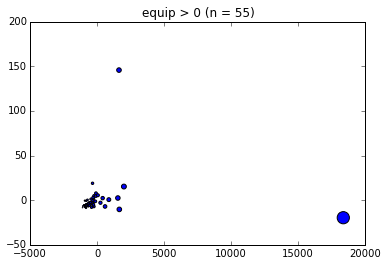

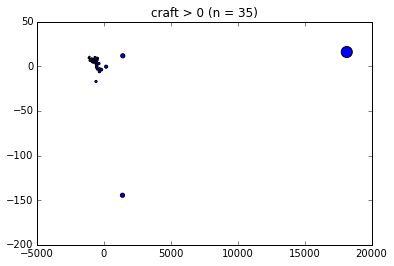

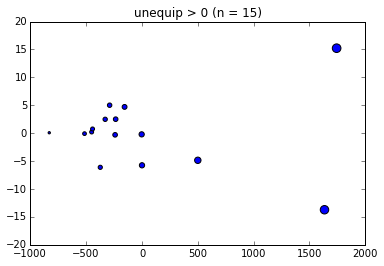

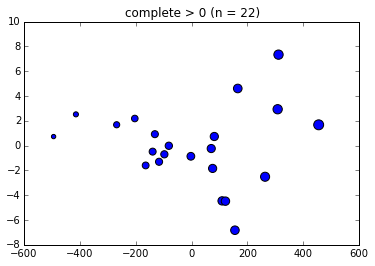

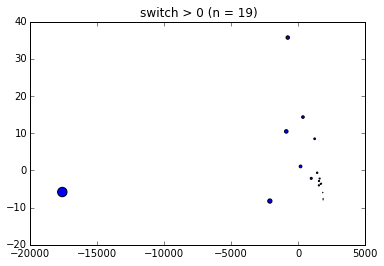

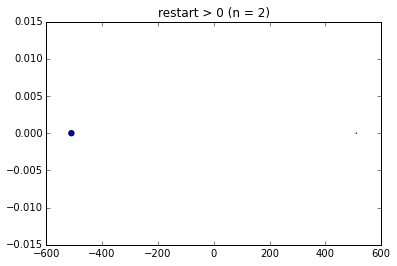

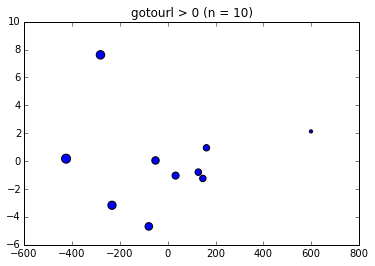

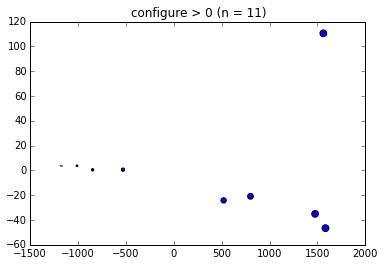

In [335]:
for title in list_types:
  df = players_stats[ players_stats[title] > 0 ] 
  
  X = df.as_matrix()
  n = X.shape[0]
  
  # print X
  # print n
  
  if n > 1:
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)

    d = 20 * df["duration (seconds)"] / df["duration (seconds)"].std()
    
    plt.figure()
    plt.scatter(X_r[:, 0], X_r[:, 1], s=d) #, c=c, label=target_name)
    plt.title("%s > 0 (n = %s)" % (title, n))
    plt.legend()
  else:
    print "we skipped %s because there is no enough data" % title

plt.show();